In [ ]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing
from keras.utils.np_utils import to_categorical

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
train_dataset = np.load('train_dataset_10k_60.npz')
val_dataset = np.load('validation_dataset_10k_40.npz')
test_dataset = np.load('test_dataset.npz')

# =========== Loading Datasets ===============

x_train = train_dataset['x'].reshape(6000, 784).astype("float32") / 255
y_train = train_dataset['y'].astype("float32")
  
x_val = val_dataset['x'].reshape(4000, 784).astype("float32") / 255
y_val = val_dataset['y'].astype("float32")   
                    
x_test = test_dataset['x'].reshape(10010, 784).astype("float32") / 255
y_test = test_dataset['y'].astype("float32")                    

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape 

((6000, 784), (6000,), (4000, 784), (4000,), (10010, 784), (10010,))

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(784,)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10)    # didn't use softmax since it will be called when (logits=true) in below step
])
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
@tf.function
def loss(w1,w2,lamda1, lamda2,loss_fn,y_train,logits): # Lambda
    total_loss = loss_fn(y_train,logits)
    return total_loss + (tf.math.exp(lamda1)*tf.nn.l2_loss(w1)+tf.math.exp(lamda2)*tf.nn.l2_loss(w2))/(2*y_train.shape[0])

In [ ]:
wt_layer1_init = model.layers[1].get_weights()
wt_layer2_init = model.layers[2].get_weights()

train_df = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_df = train_df.shuffle(buffer_size = 1024).batch(64)

def fmin_loss(lamda1, lamda2, epochs= 50, l_rate= 0.2, momentum= 0.07, nesterov = True):      # lamda, not exp(lamda), Works with both tf.Variable and tf.constant type lambda input, (or just scalar)
    tf.keras.backend.clear_session()
    optimizer = keras.optimizers.SGD(learning_rate=l_rate,momentum = momentum , nesterov =nesterov )
    total_loss0 = 1e20

    for epoch in range(epochs):
        for step,(x_train,y_train) in enumerate(train_df):
            with tf.GradientTape() as tape:
                logits = model(x_train, training=True)
                w1 = model.layers[1].weights[0]
                w2 = model.layers[2].weights[0]
                total_loss1 = loss(w1,w2,lamda1, lamda2,loss_fn,y_train,logits)
                
            vars_list = model.trainable_weights
            grads = tape.gradient(total_loss1, vars_list)      # for ref  - https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough 
            optimizer.apply_gradients(zip(grads,vars_list))

        total_loss0 = total_loss1

    wt_layer1 = model.layers[1].get_weights()
    wt_layer2 = model.layers[2].get_weights()
    model.layers[1].set_weights(wt_layer1_init)
    model.layers[2].set_weights(wt_layer2_init)

    return [total_loss1, wt_layer1, wt_layer2]

In [ ]:
def f_val(w1,b1,w2,b2,lamda1, lamda2, xtr, ytr): # lamda -> Variable
    layer1_weights = [w1,b1]
    layer2_weights = [w2,b2]
    model.layers[1].set_weights(layer1_weights)
    model.layers[2].set_weights(layer2_weights)
    logits = model(xtr)
    return loss(w1,w2,lamda1, lamda2,loss_fn,ytr,logits)

def f_grad(w1,b1,w2,b2,lamda1, lamda2, xtr, ytr): # lamda -> Variable
    with tf.GradientTape() as tape:
        total_loss = f_val(w1,b1,w2,b2,lamda1, lamda2, xtr, ytr)
    vars_list = model.trainable_weights
    vars_list.append(lamda1)
    vars_list.append(lamda2)
    grads = tape.gradient(total_loss, vars_list) 
    return grads

def F_val(w1,b1,w2,b2, xval, yval):     
    layer1_weights = [w1,b1]
    layer2_weights = [w2,b2]
    model.layers[1].set_weights(layer1_weights)
    model.layers[2].set_weights(layer2_weights)
    logits = model(xval)
    return loss_fn(yval,logits)

def F_grad(w1,b1,w2,b2, xval, yval):   # float32 arrays
    with tf.GradientTape() as tape:
        total_loss = F_val(w1,b1,w2,b2,xval,yval)
    vars_list = model.trainable_weights
    grads = tape.gradient(total_loss, vars_list) 
    return grads

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import matplotlib.pyplot as plt

def krig_conversion( lamdas ):
    Lam = []
    for lamda in lamdas:
        lamda = lamda.numpy()
        if np.isscalar(lamda) == True:
            Lam.append( lamda)
        else:
            Lam.append( lamda[0] )
    return tf.Variable(Lam, dtype = 'float32')

# NOTE: Function for prediction at multi-dimensional lamda, not multiple lamdas
def GPR( Lamda_sample, Phi_sample, lamda1, lamda2 ): # ( arr([[],[],...]), arr([[],[],...]), arr([[],[],...])  )

    lamdas = [lamda1, lamda2]
    x = np.array([krig_conversion( lamdas)])
    kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
    gaussian_process.fit(Lamda_sample, Phi_sample)

    k2_l = gaussian_process.kernel_.get_params()['k2__length_scale']
    y_pred, sigma = gaussian_process.predict(x, return_std=True)
    y_pred_grad = 0.0*y_pred

    k_val = gaussian_process.kernel_( Lamda_sample , np.atleast_2d(x) , eval_gradient=False).ravel() 
    x_diff_over_l_sq = ([lam_val-x for lam_val in Lamda_sample]/np.power(k2_l,2))#.ravel()
    intermediate_result = [k*i for k,i in zip(k_val,x_diff_over_l_sq)]
    final_result = 0
    for alpha, int_res in zip(gaussian_process.alpha_, intermediate_result):
        final_result += alpha*int_res
    final_result *= gaussian_process._y_train_std
    
    return [y_pred, final_result]


In [ ]:
def Function_Grad( w1,b1,w2,b2,lamda1,lamda2, Lamda_sample, Phi_sample, R_val, Mu_val,
                  xtr, ytr, xval, yval ):

    Phi = GPR( Lamda_sample, Phi_sample,lamda1,lamda2)
    Phi_val, Phi_grad = Phi[0], Phi[1]
    
    p1 = F_grad( w1,b1,w2,b2, xval, yval ) 
    p2 = ( R_val* ( f_val(w1,b1,w2,b2,lamda1,lamda2,xtr,ytr) -  Phi_val) + Mu_val )

    f_gradient = f_grad(w1,b1,w2,b2,lamda1,lamda2,xtr,ytr)

    p3 = f_gradient[:-2] + [f_gradient[-2].numpy()-Phi_grad[0][0],f_gradient[-1].numpy()-Phi_grad[0][1]]
    p2tp3 = [p2*elt for elt in p3]
    gradients = [e1+e2 for e1,e2 in zip(p1,p2tp3[:-2])] + p2tp3[-2:]
    gradients = [(tf.clip_by_norm(grad, clip_norm = 2.0)) for grad in gradients]
    return gradients   # Output : w1, b1, w2, b2, lamda : floar32 arrays

In [ ]:
def AugLag_Function( w1,b1,w2,b2,lamda1, lamda2, Lamda_sample, Phi_sample, R_val, Mu_val, xtr, ytr, xval, yval ):
    PHI = GPR( Lamda_sample, Phi_sample, lamda1,lamda2 )
    f_phi = f_val(w1,b1,w2,b2,lamda1,lamda2,xtr,ytr) - PHI[0]
    final_val = F_val(w1,b1,w2,b2,xval,yval) + (R_val/2) * f_phi**2 + Mu_val * f_phi
    return final_val.numpy()[0]

In [ ]:
import numpy as np

def Gradient_Descent(  w1,b1,w2,b2,lamda1,lamda2,Lamda_sample, Phi_sample, R_val, Mu_val, momentum, learning_rate,
                     batch_size=64, n_iter=500, F_tolerance=1e-6, opt_tolerance = 1e-10, dtype="float32", random_state=None ):

    seed   = None if random_state is None else int(random_state)
    rng    = np.random.default_rng(seed=seed)
    
    n_obs_tr  = x_train.shape[0]
    n_obs_val = x_val.shape[0]
    xy_train  = np.c_[x_train.reshape(n_obs_tr, -1), y_train.reshape(n_obs_tr, 1)]
    xy_val    = np.c_[x_val.reshape(n_obs_val, -1) , y_val.reshape(n_obs_val, 1) ]

    vector     = np.array( [w1, b1, w2, b2, lamda1, lamda2] )

    learn_rate = np.array(learning_rate, dtype=dtype)
    batch_size = int(batch_size)
    n_iter     = int(n_iter)
    fun_tolerance  = np.array(F_tolerance, dtype=dtype)
    diff_old       = np.array([0 for i in range(0,6)])  # difference_initial

    Z_val0, grad_old, loss_ = 1e20, 1e10, 1e20

    Z_val_track = []

    for _ in range(n_iter):
        
        rng.shuffle(xy_train)
        rng.shuffle(xy_val)

        idx_tr = np.random.randint( n_obs_tr, size=batch_size )
        idx_val = np.random.randint( n_obs_val, size=batch_size )
        #print(idx_tr,"\n\n",idx_val)
        x_batch_tr, y_batch_tr = xy_train[idx_tr, :-1], xy_train[idx_tr, -1:]
        x_batch_val, y_batch_val = xy_val[idx_val, :-1], xy_val[idx_val, -1:]

        Z_grad = Function_Grad( w1,b1,w2,b2,lamda1,lamda2, Lamda_sample, Phi_sample, R_val, Mu_val, x_batch_tr, y_batch_tr, x_batch_val, y_batch_val )
        Z_grad = np.array(Z_grad)
        diff_new = learning_rate*Z_grad

        [w1,b1,w2,b2,lamda1,lamda2] = np.array([w1,b1,w2,b2,lamda1,lamda2]) - ( learning_rate*diff_new + momentum*diff_old )
        diff_old = diff_new
        lamda1 = tf.Variable(lamda1, dtype = dtype)
        lamda2 = tf.Variable(lamda2, dtype = dtype)

        # ============= Termination Criterias Check ========================

        Z_val = AugLag_Function( w1,b1,w2,b2,lamda1, lamda2, Lamda_sample, Phi_sample, R_val, Mu_val, x_train, y_train, x_val, y_val )

        F_tol = abs(Z_val-Z_val0)/(1+abs(Z_val0))
        grad_tol = np.array( [np.linalg.norm(g, ord = np.inf) for g in Z_grad ] )
        Z_val0 = Z_val
        Z_val_track.append(Z_val)
        if np.all(grad_tol) <= opt_tolerance and F_tol <= F_tolerance:
            opt_weights = [w1,b1,w2,b2,lamda1,lamda2]
            loss_ = Z_val
            break
        elif Z_val <= loss_ :
            loss_ = Z_val
            opt_weights = [w1,b1,w2,b2,lamda1,lamda2]
    plt.plot(np.array(Z_val_track), linestyle = 'dotted')
    plt.show()
    return opt_weights, loss_

In [ ]:
# GLOBAL : Lamda_sample, Phi_sample
def Augmented_Lagrangian( w1, b1, w2, b2, lamda1, lamda2, Lamda_sample, Phi_sample, mom, lr, R_val = 2, Mu_val = 2, neta = 1.5, al_epochs = 5 ):
    Z_val0 = 1e+20
    Lamda_sampleL, Phi_sampleL = Lamda_sample, Phi_sample
    wts_opt0, lamda_opt10, lamda_opt20, min_violation = [], 0, 0, 10
    for epoch in range(al_epochs):

        Opt_Weights, _ = Gradient_Descent( w1,b1,w2,b2,lamda1, lamda2, Lamda_sampleL, Phi_sampleL, R_val, Mu_val, mom, lr )
        w1_opt,b1_opt,w2_opt,b2_opt, lamda_opt1, lamda_opt2 = Opt_Weights[0], Opt_Weights[1], Opt_Weights[2], Opt_Weights[3], Opt_Weights[4],Opt_Weights[5]  # lamda not var
        lamda_opt1 = tf.Variable(lamda_opt1, dtype=tf.float32)        
        lamda_opt2 = tf.Variable(lamda_opt2, dtype=tf.float32)

        # ========== NOT USED ====================
        #w1,b1,w2,b2,lamda1,lamda2 = w1_opt,b1_opt,w2_opt,b2_opt,lamda_opt1,lamda_opt2 
        Phi1 = GPR(Lamda_sampleL, Phi_sampleL, lamda1, lamda2)
        Phi_val1 = Phi1[0]

        # ==========UPDATING LAMBDA SAMPLE FOR GPR=========================
        
        Lamda_sampleL = np.array(np.vstack([Lamda_sampleL,[lamda_opt1.numpy()[0],lamda_opt2.numpy()[0]]]), dtype = 'float32')
        index = np.where(Lamda_sampleL == [lamda_opt1.numpy()[0],lamda_opt2.numpy()[0]] )
        Phi_new_lamda = fmin_loss(lamda_opt1,lamda_opt2)[0].numpy()
        Phi_sampleL = np.insert(Phi_sampleL, index[0][0], Phi_new_lamda)

        #print("\n Phi_new_lamda = ", Phi_new_lamda)

        # ============== Updating Augmented Lagrangian Parameters ====================
        constraint_ = f_val(w1_opt,b1_opt,w2_opt,b2_opt,lamda_opt1,lamda_opt2,x_train,y_train) - Phi_val1
        Mu_val = Mu_val + R_val*( constraint_ )
        R_val  = neta*R_val

        # ===== Constraint Violation Criteria ===================
        violation = abs(constraint_)
        print(f"\n {epoch} :: Violation = {violation}, Lambdas = {lamda_opt1.numpy(), lamda_opt2.numpy()}")
        if violation <= min_violation:
          wts_opt0 = [ [w1_opt, b1_opt], [w2_opt, b2_opt]]
          lamda_opt10, lamda_opt20 = lamda_opt1, lamda_opt2
          min_violation = violation
      
    print(f"\n\n AL Ended With Violation :: {min_violation}, Optimal Lambdas = {lamda_opt10, lamda_opt20}")
    return wts_opt0, lamda_opt10, lamda_opt20

In [ ]:
Lamda_sample1 = np.linspace( 0, -10, num = 5, endpoint = True, dtype = 'float32' )

Lamda_sample = []
for x in Lamda_sample1:
    for y in Lamda_sample1:
            Lamda_sample.append( [x, y] )
Lamda_sample = np.array(Lamda_sample)

Phi_sample, Weights, lamda_init = [], [], 0
init_val_loss = 1e20

for lamda in Lamda_sample:
    
    [min_loss, layer1wt, layer2wt] = fmin_loss(lamda[0],lamda[1])
    Phi_sample.append( min_loss.numpy() )
    
    model.layers[1].set_weights(layer1wt)
    model.layers[2].set_weights(layer2wt)
    val_logits = model(x_val)
    val_loss = loss_fn(y_val,val_logits)
    if val_loss <= init_val_loss :
        init_val_loss = val_loss
        Weights = [layer1wt, layer2wt]
        lamda_init1 = lamda[0]
        lamda_init2 = lamda[1]

Phi_sample = np.array(Phi_sample)
print("\n\n Phi_sample: ", Phi_sample, "\n\n")

#============================== Initializing Weights =================================================
w1, b1 = Weights[0][0], Weights[0][1]
w2, b2 = Weights[1][0], Weights[1][1]
lamda1 = tf.Variable(lamda_init1, dtype = tf.float32)
lamda2 = tf.Variable(lamda_init2, dtype = tf.float32)




 Phi_sample:  [0.47773188 0.31078675 0.17872639 0.23356026 0.19826691 0.20718734
 0.0982402  0.04568855 0.02978057 0.02833833 0.12841132 0.03145272
 0.01492578 0.01167002 0.01089001 0.08577217 0.01518274 0.00420207
 0.00181743 0.00173079 0.08206387 0.01454639 0.00195624 0.00059998
 0.00072757] 




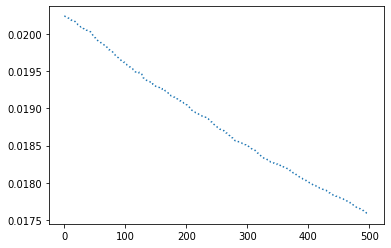


 LR : 0.0010000000474974513, MOM : 0.1, Z_VAL : 0.017580687999725342


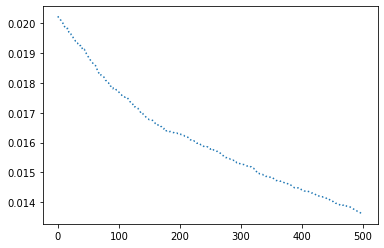


 LR : 0.0010000000474974513, MOM : 0.5, Z_VAL : 0.013608820736408234


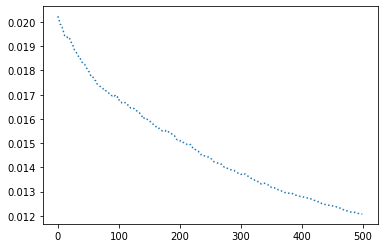


 LR : 0.0010000000474974513, MOM : 0.8, Z_VAL : 0.012074559926986694


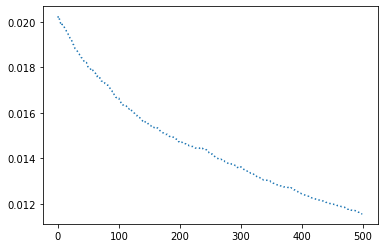


 LR : 0.0010000000474974513, MOM : 0.9, Z_VAL : 0.011563926935195923


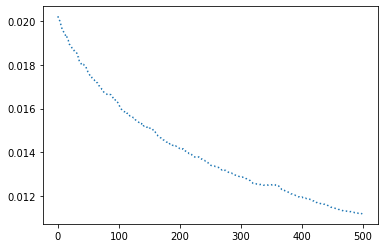


 LR : 0.0010000000474974513, MOM : 0.99, Z_VAL : 0.011168628931045532


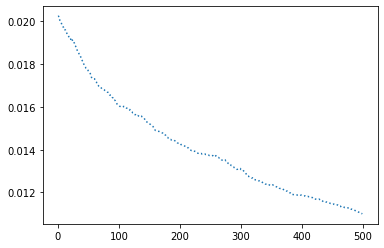


 LR : 0.009999999776482582, MOM : 0.1, Z_VAL : 0.010997474193572998


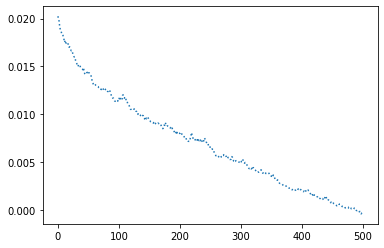


 LR : 0.009999999776482582, MOM : 0.5, Z_VAL : -0.0003677457571029663


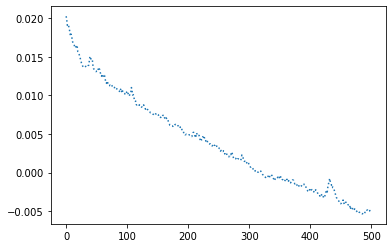


 LR : 0.009999999776482582, MOM : 0.8, Z_VAL : -0.005358636379241943


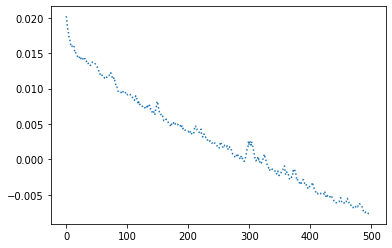


 LR : 0.009999999776482582, MOM : 0.9, Z_VAL : -0.00772201269865036


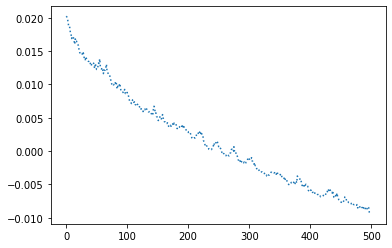


 LR : 0.009999999776482582, MOM : 0.99, Z_VAL : -0.009436376392841339


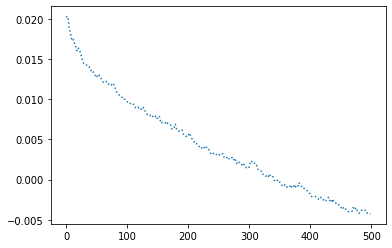


 LR : 0.05000000074505806, MOM : 0.1, Z_VAL : -0.004266232252120972


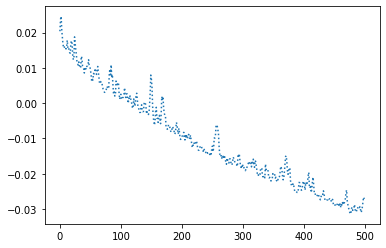


 LR : 0.05000000074505806, MOM : 0.5, Z_VAL : -0.031365543603897095


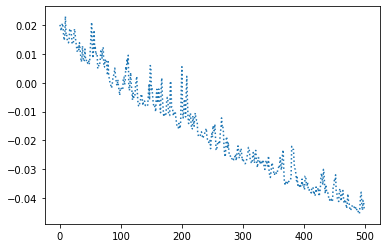


 LR : 0.05000000074505806, MOM : 0.8, Z_VAL : -0.045445509254932404


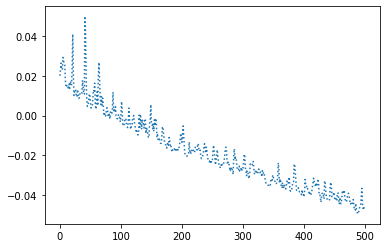


 LR : 0.05000000074505806, MOM : 0.9, Z_VAL : -0.049522630870342255


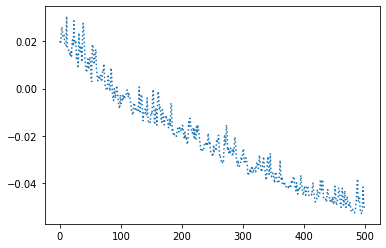


 LR : 0.05000000074505806, MOM : 0.99, Z_VAL : -0.05289989709854126


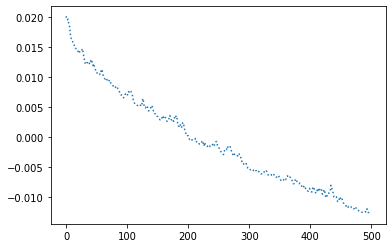


 LR : 0.07000000029802322, MOM : 0.1, Z_VAL : -0.01275971531867981


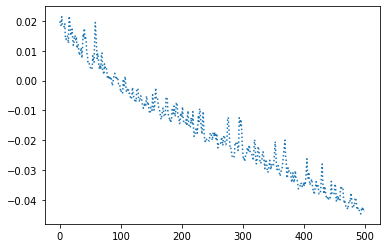


 LR : 0.07000000029802322, MOM : 0.5, Z_VAL : -0.044729866087436676


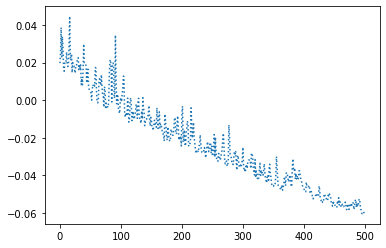


 LR : 0.07000000029802322, MOM : 0.8, Z_VAL : -0.06044204533100128


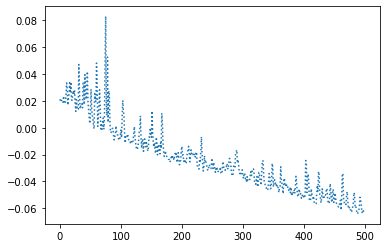


 LR : 0.07000000029802322, MOM : 0.9, Z_VAL : -0.06411994993686676


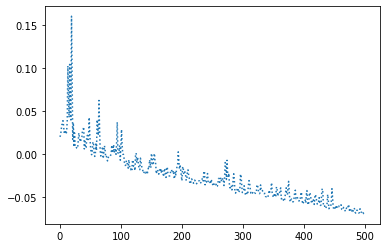


 LR : 0.07000000029802322, MOM : 0.99, Z_VAL : -0.06946675479412079


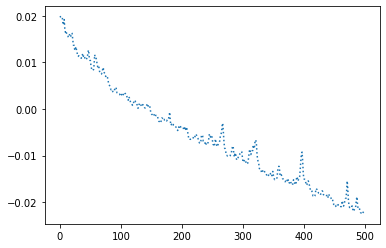


 LR : 0.10000000149011612, MOM : 0.1, Z_VAL : -0.02250918745994568


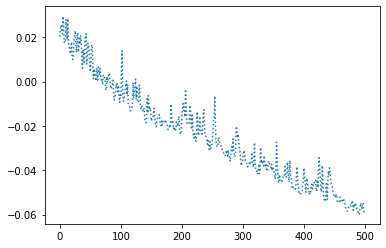


 LR : 0.10000000149011612, MOM : 0.5, Z_VAL : -0.059690847992897034


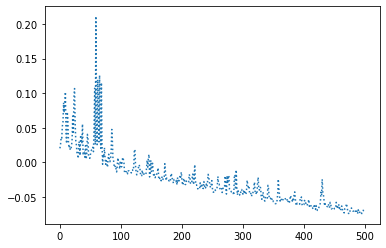


 LR : 0.10000000149011612, MOM : 0.8, Z_VAL : -0.07477864623069763


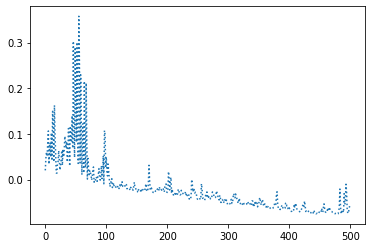


 LR : 0.10000000149011612, MOM : 0.9, Z_VAL : -0.07519569993019104


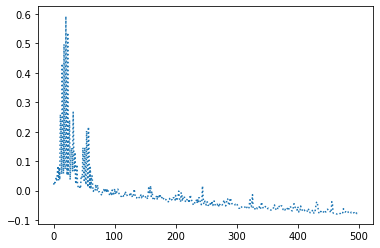


 LR : 0.10000000149011612, MOM : 0.99, Z_VAL : -0.07902604341506958


 Optimum :  -0.07902604  Momentum : 0.99, LR : 0.10000000149011612


In [ ]:
#learn_rate = np.arange( 0.1, 0.9, 0.1, dtype = 'float32' )
learn_rate = np.array( [0.001, 0.01, 0.05, 0.07, 0.1], dtype = 'float32' )
# momentum_set = np.arange( 0.01, 0.1, 0.01 )
momentum_set = np.array( [0.1, 0.5, 0.8, 0.9, 0.99] )
opt_val = 1e20
l0,m0 = 0,0
for lr in learn_rate:
    for mom in momentum_set:
        w1, b1 = Weights[0][0], Weights[0][1]
        w2, b2 = Weights[1][0], Weights[1][1]
        lamda1 = tf.Variable(lamda_init1, dtype = tf.float32)
        lamda2 = tf.Variable(lamda_init2, dtype = tf.float32)

        wt, val= Gradient_Descent( w1,b1,w2,b2,lamda1,lamda2,Lamda_sample, Phi_sample, R_val = 2, Mu_val = 2,  momentum = mom, learning_rate = lr )
        print("\n LR : {}, MOM : {}, Z_VAL : {}".format(lr,mom,val))
       
        if val <= opt_val:
            opt_val = val
            l0,m0 = lr,mom
print("\n\n Optimum : ",  opt_val, " Momentum : {}, LR : {}".format(m0,l0))

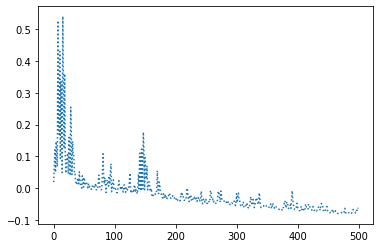


 0 :: Violation = [0.07452977], Lambdas = (array([-11.835446], dtype=float32), array([-0.878959], dtype=float32))


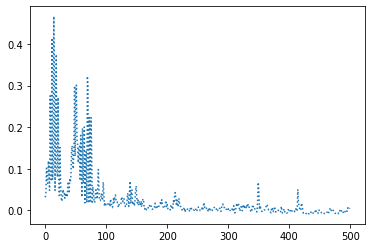


 1 :: Violation = [0.07398235], Lambdas = (array([-10.138806], dtype=float32), array([-0.8639356], dtype=float32))


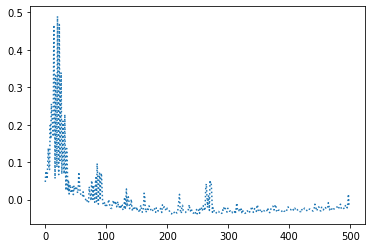


 2 :: Violation = [0.06972016], Lambdas = (array([-10.265352], dtype=float32), array([0.3160774], dtype=float32))


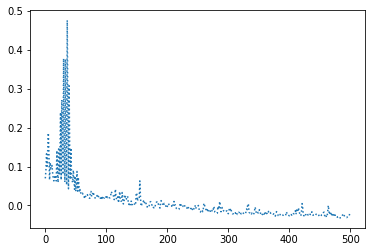


 3 :: Violation = [0.07024422], Lambdas = (array([-8.860687], dtype=float32), array([-0.18199934], dtype=float32))


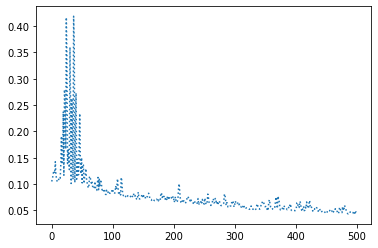


 4 :: Violation = [0.06995589], Lambdas = (array([-9.810269], dtype=float32), array([-0.22213198], dtype=float32))


 AL Ended With Violation :: [0.06972016], Optimal Lambdas = (<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([-10.265352], dtype=float32)>, <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.3160774], dtype=float32)>)


 Optimal_Lambda =  -10.265352 0.3160774 

RUN 0 :: Validation Loss : 0.09800505638122559, Training Loss : 0.011364667676389217, Testing Loss : 0.1710939109325409


In [ ]:
# ===========FINDING LOSS=======================
#w1_f,b1_f,w2_f,b2_f,lamda_f

for run in range(1):

    w1, b1 = Weights[0][0], Weights[0][1]
    w2, b2 = Weights[1][0], Weights[1][1]
    lamda1 = tf.Variable(lamda_init1, dtype = tf.float32)
    lamda2 = tf.Variable(lamda_init2, dtype = tf.float32)

    wt_final, lamda_final1, lamda_final2 = Augmented_Lagrangian( w1, b1, w2, b2, lamda1, lamda2, Lamda_sample, Phi_sample, m0, l0 )
    Final_weights_1, Final_weights_2 = wt_final[0], wt_final[1]

    model.layers[1].set_weights(Final_weights_1)
    model.layers[2].set_weights(Final_weights_2)

    val_logits = model(x_val)
    val_loss = loss_fn(y_val,val_logits)

    train_logits = model(x_train)
    training_loss = loss_fn(y_train,train_logits)

    test_logits = model(x_test)
    test_loss = loss_fn(y_test,test_logits)

    print("\n\n Optimal_Lambda = ", lamda_final1.numpy()[0],lamda_final2.numpy()[0], "\n")
    print(f'RUN {run} :: Validation Loss : {val_loss}, Training Loss : {training_loss}, Testing Loss : {test_loss}')

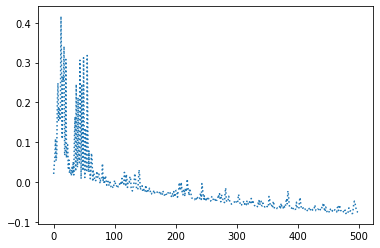


 0 :: Violation = [0.07433666], Lambdas = (array([-11.82504], dtype=float32), array([-0.86074144], dtype=float32))


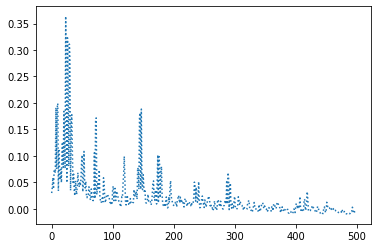


 1 :: Violation = [0.07430134], Lambdas = (array([-10.196699], dtype=float32), array([-0.9139209], dtype=float32))


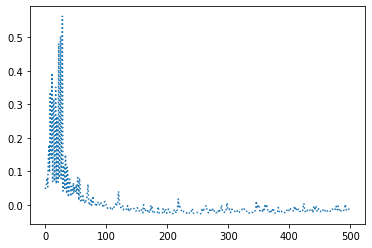


 2 :: Violation = [0.06903125], Lambdas = (array([-10.270995], dtype=float32), array([0.2045385], dtype=float32))


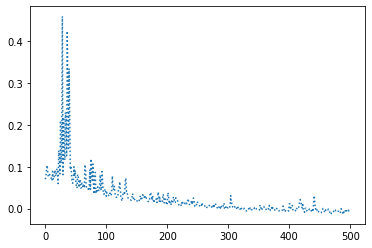


 3 :: Violation = [0.07059503], Lambdas = (array([-8.979006], dtype=float32), array([-0.22708927], dtype=float32))


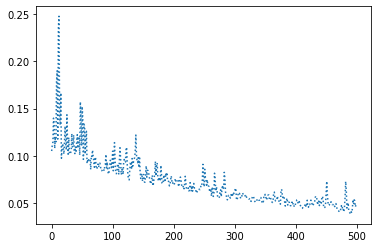


 4 :: Violation = [0.0700781], Lambdas = (array([-9.557795], dtype=float32), array([-0.03397251], dtype=float32))


 AL Ended With Violation :: [0.06903125], Optimal Lambdas = (<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([-10.270995], dtype=float32)>, <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.2045385], dtype=float32)>)


 Optimal_Lambda =  -10.270995 0.2045385 

RUN 0 :: Validation Loss : 0.09541483223438263, Training Loss : 0.012163477949798107, Testing Loss : 0.17308828234672546


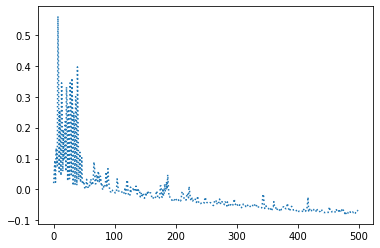


 0 :: Violation = [0.07469882], Lambdas = (array([-11.856078], dtype=float32), array([-0.86914307], dtype=float32))


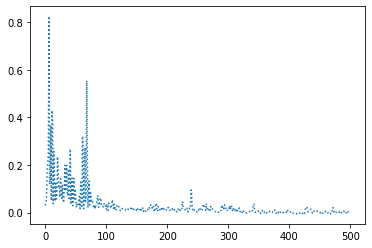


 1 :: Violation = [0.0736298], Lambdas = (array([-10.06336], dtype=float32), array([-0.90915024], dtype=float32))


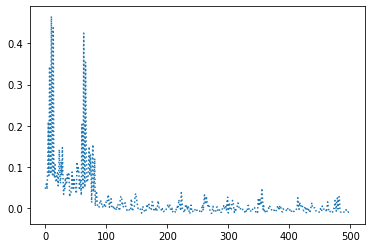


 2 :: Violation = [0.07057063], Lambdas = (array([-10.225871], dtype=float32), array([0.04453762], dtype=float32))


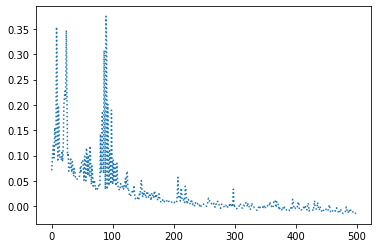


 3 :: Violation = [0.07190502], Lambdas = (array([-8.970278], dtype=float32), array([-0.18259977], dtype=float32))


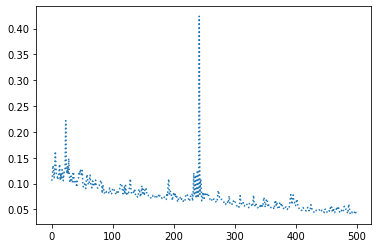


 4 :: Violation = [0.06826609], Lambdas = (array([-9.477685], dtype=float32), array([0.09004527], dtype=float32))


 AL Ended With Violation :: [0.06826609], Optimal Lambdas = (<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([-9.477685], dtype=float32)>, <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.09004527], dtype=float32)>)


 Optimal_Lambda =  -9.477685 0.090045266 

RUN 1 :: Validation Loss : 0.07494689524173737, Training Loss : 0.012899215333163738, Testing Loss : 0.1744312047958374


In [ ]:
# ===========FINDING LOSS=======================
#w1_f,b1_f,w2_f,b2_f,lamda_f

for run in range(2):

    w1, b1 = Weights[0][0], Weights[0][1]
    w2, b2 = Weights[1][0], Weights[1][1]
    lamda1 = tf.Variable(lamda_init1, dtype = tf.float32)
    lamda2 = tf.Variable(lamda_init2, dtype = tf.float32)

    wt_final, lamda_final1, lamda_final2 = Augmented_Lagrangian( w1, b1, w2, b2, lamda1, lamda2, Lamda_sample, Phi_sample, m0, l0 )
    Final_weights_1, Final_weights_2 = wt_final[0], wt_final[1]

    model.layers[1].set_weights(Final_weights_1)
    model.layers[2].set_weights(Final_weights_2)

    val_logits = model(x_val)
    val_loss = loss_fn(y_val,val_logits)

    train_logits = model(x_train)
    training_loss = loss_fn(y_train,train_logits)

    test_logits = model(x_test)
    test_loss = loss_fn(y_test,test_logits)

    print("\n\n Optimal_Lambda = ", lamda_final1.numpy()[0],lamda_final2.numpy()[0], "\n")
    print(f'RUN {run} :: Validation Loss : {val_loss}, Training Loss : {training_loss}, Testing Loss : {test_loss}')